In [2]:
from __future__ import division
import pandas as pd
import numpy as np
from random import sample
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
%matplotlib inline

# Load data

In [14]:
data = pd.read_csv('data_recruiting_bi_data_challenge.csv', ',')
data.hotel_id = data.hotel_id.astype(int).astype(str)
data = data.iloc[:,1:].set_index('hotel_id')

In [15]:
data.dtypes

city_id                  int64
clicks                 float64
stars                    int64
distance_to_center       int64
avg_price_hotel        float64
rating                 float64
nmbr_partners_index    float64
avg_rel_saving         float64
avg_rank               float64
dtype: object

In [16]:
data.head()

,city_id,clicks,stars,distance_to_center,avg_price_hotel,rating,nmbr_partners_index,avg_rel_saving,avg_rank
hotel_id,,,,,,,,,
155796153,738,256,4,554,127,73,1.12,17,11.4252
155827306,738,NaN,4,624,96,79,0.58,0,13.9176
155858459,738,349,4,434,137,85,1.57,9,3.3073
155889612,738,NaN,4,5391,133,87,0.84,4,8.9400
155920765,772,3,3,3922,120,88,1.06,2,9.5752


### Dataset size and test/train ratio

In [17]:
cases_n = data.shape[0]
print cases_n
data.clicks.isnull().sum() / data.shape[0]

832085


0.3333337339334323

### Prepare train set without NaN in nmbr_partners_index, avg_rel_saving, avg_rank

In [77]:
data[data.clicks.isnull()].head()

,city_id,clicks,stars,distance_to_center,avg_price_hotel,rating,nmbr_partners_index,avg_rel_saving,avg_rank
hotel_id,,,,,,,,,
155827306,738,NaN,4,624,96,79,0.58,0,13.9176
155889612,738,NaN,4,5391,133,87,0.84,4,8.9400
156076530,772,NaN,4,5087,NaN,86,0.29,0,15.4985
156169989,772,NaN,3,5256,109,87,1.55,4,11.1274
156356907,806,NaN,3,597,127,82,0.66,1,29.4462


In [78]:
train = data[data.clicks.isnull() == False]
train.shape

(554723, 9)

In [79]:
train = data[data.clicks.isnull() == False]
train_nan = train[(train.nmbr_partners_index.isnull())|
                  (train.avg_rank.isnull())|
                  (train.avg_rel_saving.isnull())]
train_rest = train[train.index.isin(train_nan.index) == False]
train_rest.shape

(236654, 9)

# Explore feature statistics

In [80]:
data.describe()

,city_id,clicks,stars,distance_to_center,avg_price_hotel,rating,nmbr_partners_index,avg_rel_saving,avg_rank
count,832085.000000,554723.000000,832085.000000,832085.000000,188071.000000,386220.000000,475936.000000,354522.000000,475752.000000
mean,84460.172890,20.974867,0.921631,19034.067389,101.874255,80.101126,0.709291,6.643715,127.015384
std,114494.468377,169.208896,1.444946,372891.133008,97.334982,6.333653,0.449657,10.635410,361.485707
min,0.000000,0.000000,-1.000000,-1.000000,6.000000,38.000000,0.070000,0.000000,1.000000
25%,18706.000000,0.000000,0.000000,505.000000,58.000000,77.000000,0.330000,0.000000,5.082975
50%,32312.000000,0.000000,0.000000,1509.000000,84.000000,81.000000,0.640000,1.000000,19.682100
75%,73744.000000,2.000000,2.000000,4100.000000,118.000000,84.000000,1.000000,10.000000,80.501400
max,428368.000000,30106.000000,5.000000,18650059.000000,9995.000000,97.000000,5.280000,90.000000,5704.814800


In [81]:
data.isnull().sum(axis=0)

city_id                     0
clicks                 277362
stars                       0
distance_to_center          0
avg_price_hotel        644014
rating                 445865
nmbr_partners_index    356149
avg_rel_saving         477563
avg_rank               356333
dtype: int64

In [82]:
data.isnull().sum(axis=0) / cases_n

city_id                0.000000
clicks                 0.333334
stars                  0.000000
distance_to_center     0.000000
avg_price_hotel        0.773976
rating                 0.535841
nmbr_partners_index    0.428020
avg_rel_saving         0.573935
avg_rank               0.428241
dtype: float64

In [83]:
data.city_id.value_counts().head(10)

25084    6025
13628    4692
13437    4377
22235    3746
3848     3580
17399    3439
15288    3420
31499    3056
31482    2696
24979    2446
dtype: int64

### NaN columns click statistics

In [84]:
for col in train.columns[2:]:
    if len(train[train[col].isnull()]) > 0:
        print col
        print train[train[col].isnull()].clicks.describe()
        print

avg_price_hotel
count    429105.000000
mean          2.612479
std          20.439294
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2572.000000
Name: clicks, dtype: float64

rating
count    297138.000000
mean          0.481049
std           6.439743
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1245.000000
Name: clicks, dtype: float64

nmbr_partners_index
count    237346
mean          0
std           0
min           0
25%           0
50%           0
75%           0
max           0
Name: clicks, dtype: float64

avg_rel_saving
count    318057.000000
mean          0.002034
std           0.173205
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          56.000000
Name: clicks, dtype: float64

avg_rank
count    237466.000000
mean          0.000017
std           0.006489
min           0.000000
25%           0.000000
50%           0.00

In [85]:
print train[train.nmbr_partners_index.isnull()].shape
print train[train.avg_rank.isnull()].shape

(237346, 9)
(237466, 9)


In [86]:
set1 = set(train.nmbr_partners_index.index)
set2 = set(train.avg_rank.index)
print len(set1.intersection(set2)) / len(set1)
print len(set1.intersection(set2)) / len(set2)

1.0
1.0


### Clicks

554723 277362
0.0387490693553
0.70204047786


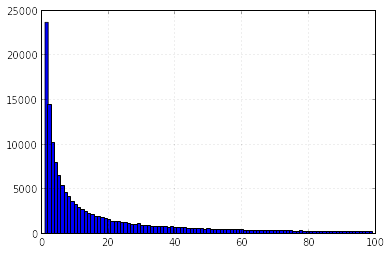

In [87]:
clicks_ser = data.clicks[data.clicks.isnull() == False]
train_cases_n = clicks_ser.shape[0]
test_cases_n = cases_n - train_cases_n
print train_cases_n, test_cases_n
print clicks_ser[clicks_ser > 100].shape[0] / train_cases_n
print clicks_ser[clicks_ser == 0].shape[0] / train_cases_n
clicks_ser[(clicks_ser > 0)&(clicks_ser < 100)].hist(bins=99)

### Stars

( 0    567245
  3    109106
  2     81031
  4     51482
  5     12127
  1     11013
 -1        81
 dtype: int64, <matplotlib.axes.AxesSubplot at 0x211b4dd0>)

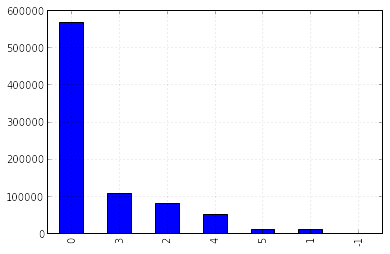

In [88]:
data.stars.value_counts(), data.stars.value_counts().plot(kind='bar')

### City_id

TopN cities dataset coverage.

In [98]:
city_id_val_cnt = data.city_id.value_counts()
base_n = 10
for p in range(0,6):
    print base_n**p, city_id_val_cnt.head(base_n**p).sum() / cases_n

1 0.00724084678849
10 0.0450398697248
100 0.158972941466
1000 0.402369950185
10000 0.782541447088
100000 1.0


City hotels number distribution.

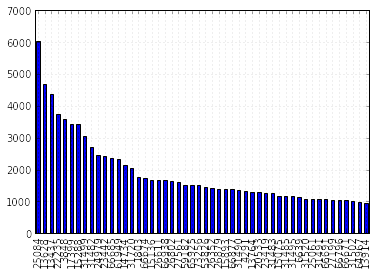

In [101]:
data.city_id.value_counts().head(50).plot(kind='bar')

### Distance_to_center

In [102]:
data.distance_to_center[data.distance_to_center > 20000].shape[0] / cases_n

0.03953922976618975

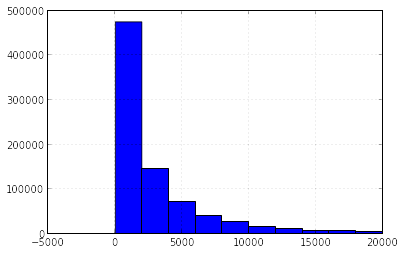

In [103]:
data.distance_to_center[data.distance_to_center < 20000].hist()

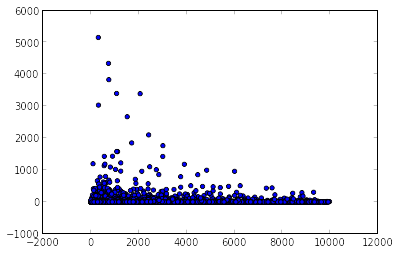

In [104]:
data_s = data.loc[sample(data.index, 10000)]
data_s = data_s[(data_s.distance_to_center<10000)&(data_s.clicks.isnull() == False)]
plt.scatter(data_s.distance_to_center, data_s.clicks)

### Avg_price_hotel

In [105]:
data[data.avg_price_hotel>250].shape[0] / cases_n

0.008805590774980922

Proportion of cases with NaN avg_price value

In [106]:
data[data.avg_price_hotel.isnull() == False].shape[0] / cases_n

0.22602378362787456

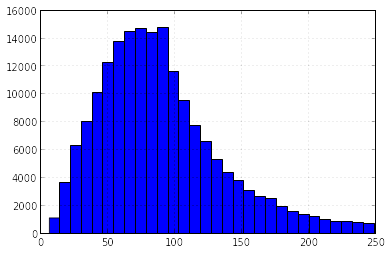

In [110]:
data[data.avg_price_hotel<250].avg_price_hotel.hist(bins=30)

Avg_price_hotel, log(clicks) scatter plot

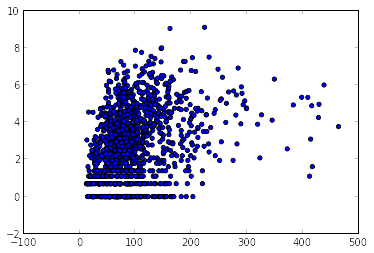

In [112]:
data_s = data.loc[sample(data.index, 10000)]
data_s = data_s[(data_s.avg_price_hotel<500)&(data_s.clicks.isnull() == False)]
plt.scatter(data_s.avg_price_hotel, np.log(data_s.clicks))

### Rating

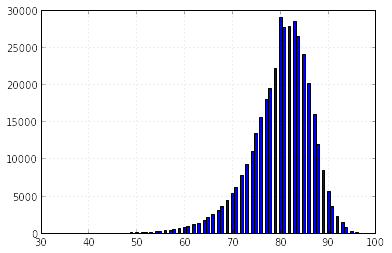

In [113]:
data.rating.hist(bins=100)

Rating, log(clicks) scatter plot

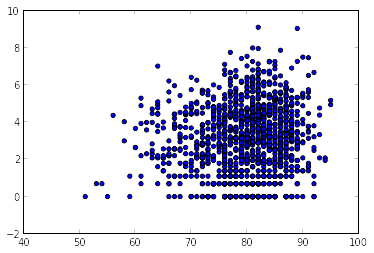

In [116]:
plt.scatter(data_s.rating, np.log(data_s.clicks))

### Nmbr_partners_index

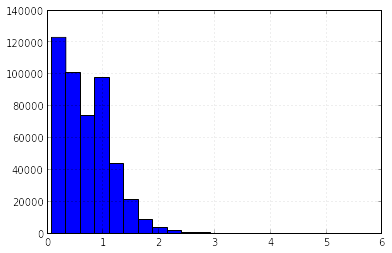

In [117]:
data.nmbr_partners_index.hist(bins=20)

Nmbr_partners_index, log(clicks) scatter plot

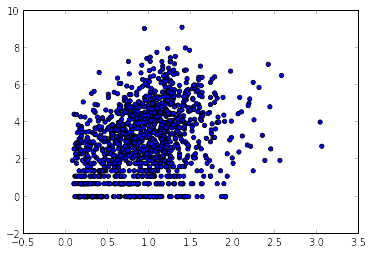

In [120]:
plt.scatter(data_s.nmbr_partners_index, np.log(data_s.clicks))

### Avg_rel_saving

In [121]:
data[data.avg_rel_saving > 50].shape[0] / cases_n

0.0027172704711658064

In [122]:
data[data.avg_rel_saving < 1].shape[0] / cases_n

0.20783934333631782

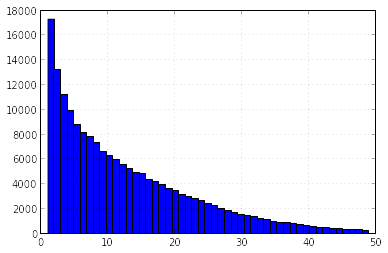

In [123]:
data[(data.avg_rel_saving > 0)&(data.avg_rel_saving < 50)].avg_rel_saving.hist(bins=49)

Avg_rel_saving, log(clicks) scatter plot

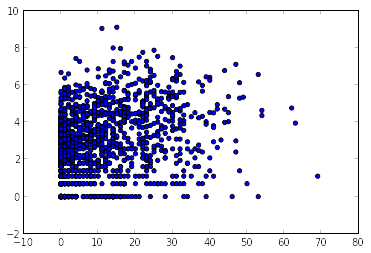

In [124]:
plt.scatter(data_s.avg_rel_saving, np.log(data_s.clicks))

### Avg_rank

In [125]:
data[data.avg_rank>500].shape[0] / cases_n

0.035326919725749174

Portion of NaN avg_ranks

In [126]:
data.avg_rank.isnull().sum() / cases_n

0.42824110517555297

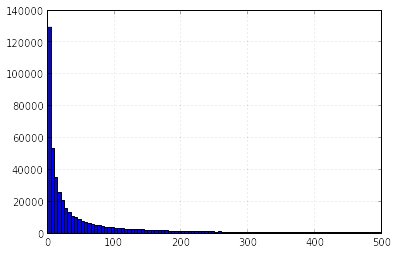

In [128]:
data[(data.avg_rank.isnull() == False)&(data.avg_rank<500)].avg_rank.hist(bins=100)

In [129]:
data.avg_rank.isnull().sum()

356333

Clicks distribution for cases where avg_rank is NaN

In [131]:
data[data.avg_rank.isnull()].clicks.value_counts()

0    237464
3         1
1         1
dtype: int64

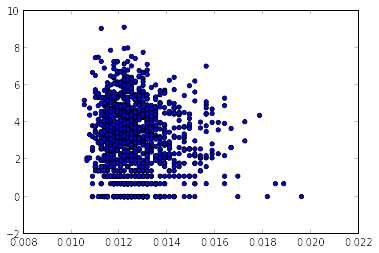

In [137]:
plt.scatter(1/data_s.rating, np.log(data_s.clicks))

### Hotel id

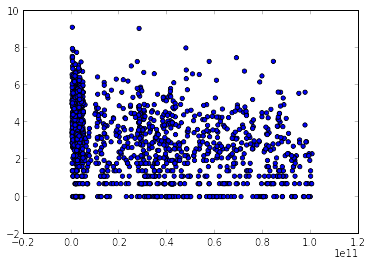

In [139]:
plt.scatter(data_s.index.astype(int), np.log(data_s.clicks))

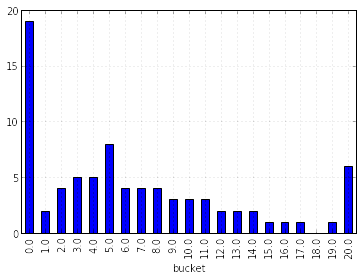

In [160]:
data_cp = train_rest.copy()
n = 20
data_cp['bucket'] = np.floor(data_cp.index.astype(int) / (data_cp.index.astype(int).max() / n))
data_cp.groupby('bucket').clicks.median().plot(kind='bar')

# Nearest Neighbors in the City

In [176]:
city_id_val_cnt = train.city_id.value_counts()
city_id_val_cnt[city_id_val_cnt < 100].head()

81682    99
68104    99
66694    99
13546    99
13966    99
dtype: int64

Portion of hotels located in cities with less or equal to 2 hotels

In [162]:
city_id_val_cnt[city_id_val_cnt <= 2].sum() / len(train)

0.068901055121204632

In [66]:
city_ids = city_id_val_cnt[city_id_val_cnt == 1].index
train_rest[train_rest.city_id.isin(city_ids)].sort('clicks', ascending=False).clicks.mean()

5.2673443456162641

### City hotel neighbors search

In [179]:
city_id = 13546
city_tr_data = tr_rest_data[tr_rest_data.city_id == city_id].fillna(0)
print city_tr_data.shape
# city_tr_data.sort('clicks', ascending=False).head()
city_tr_data.head(10)

(38, 9)


,city_id,clicks,stars,distance_to_center,avg_price_hotel,rating,nmbr_partners_index,avg_rel_saving,avg_rank
hotel_id,,,,,,,,,
219285967,13546,591,4,2698,113,81,1.47,18,4.9231
219317120,13546,101,4,8117,0,73,0.25,0,33.4641
219410579,13546,418,4,9374,176,76,0.82,15,9.7017
1246556142,13546,565,5,3503,226,86,1.90,41,7.4975
1253534414,13546,609,5,4143,147,81,1.25,34,7.8482
1258674659,13546,234,0,12166,210,89,1.23,15,7.2544
1265715237,13546,364,4,12577,95,72,1.51,28,9.5134
1266338297,13546,47,0,8884,100,83,0.27,0,22.5267
2613861312,13546,13,0,267,0,78,0.26,2,26.2705


In [180]:
city_tr_data_X = city_tr_data.iloc[:,2:]
city_tr_data_X_norm = (city_tr_data_X - city_tr_data_X.mean()) / (city_tr_data_X.max() - city_tr_data_X.min())

In [181]:
nbrs = NearestNeighbors(n_neighbors=5, p=2)
nbrs.fit(city_tr_data_X_norm)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_neighbors=5, p=2, radius=1.0)

In [184]:
target_hotel_id = '219285967'
nbr_dists, nbr_inds = nbrs.kneighbors(city_tr_data_X_norm.loc[target_hotel_id])

Hotel 219285967 top 5 neighbors in city 13546

In [185]:
df = city_tr_data.iloc[nbr_inds[0]].copy()
df['dist'] = nbr_dists[0]
df

,city_id,clicks,stars,distance_to_center,avg_price_hotel,rating,nmbr_partners_index,avg_rel_saving,avg_rank,dist
hotel_id,,,,,,,,,,
219285967,13546,591,4,2698,113,81,1.47,18,4.9231,0.000000
41113673302,13546,605,4,4837,94,84,1.25,21,8.5201,0.237211
1253534414,13546,609,5,4143,147,81,1.25,34,7.8482,0.482223
3342000381,13546,988,4,545,73,68,1.73,41,6.1952,0.633570
3031747654,13546,383,4,9890,81,69,1.08,25,16.8305,0.674721


Scatter plots for different features

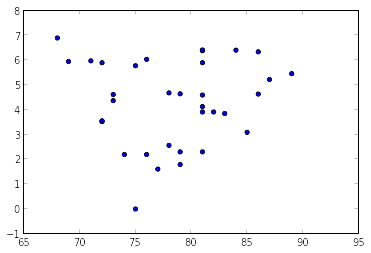

In [189]:
plt.scatter(city_tr_data.rating[city_tr_data.rating>0], np.log(city_tr_data[city_tr_data.rating>0].clicks))

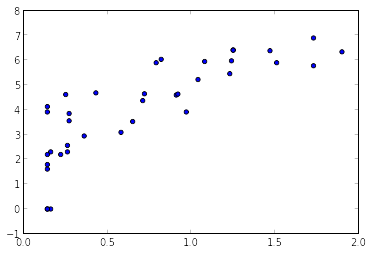

In [186]:
plt.scatter(city_tr_data.nmbr_partners_index, np.log(city_tr_data.clicks))

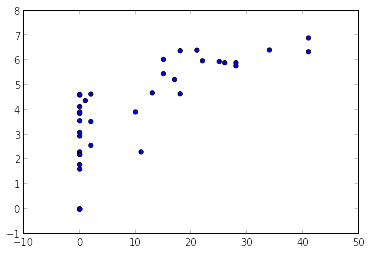

In [190]:
plt.scatter(city_tr_data.avg_rel_saving, np.log(city_tr_data.clicks))

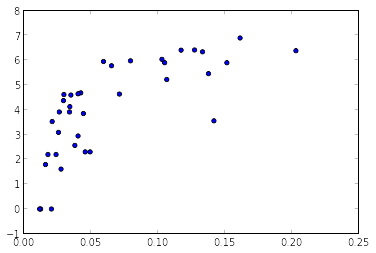

In [192]:
plt.scatter(1/city_tr_data.avg_rank, np.log(city_tr_data.clicks))